In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
url = '/content/drive/MyDrive/Assignment 2/'

In [6]:
dataset_C = url + 'dataset_2_image.zip'
with ZipFile(dataset_C, 'r') as zip:
  zip.extractall()

In [7]:
PATH = '/content/'
train_data_labels = pd.read_csv('/content/csv/updatetrain.csv', usecols = ['filename', 'digit'])
test_data_labels = pd.read_csv('/content/csv/updatetest.csv', usecols = ['filename', 'digit'])
train_data_labels.head()


,filename,digit
0,0.jpg,9
1,1.jpg,0
2,2.jpg,0
3,3.jpg,3
4,4.jpg,0


In [8]:
TRAIN_PATH = url + 'Train'
os.mkdir(TRAIN_PATH)

def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) 

processImages('training-a')

FileExistsError: ignored

In [9]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [10]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(train_data_labels, '/content/train', train_transform)
test_data = Dataset(test_data_labels, '/content/test_28', test_transform)

print("Trainig Samples: ", len(train_data))

Trainig Samples:  60000


# **Base Parameters**

In [20]:
batch_size = 90
num_iters = 20000
input_dim = 28*28
num_hidden = 220
output_dim = 10

learning_rate = 0.001

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

30


In [21]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:534
Test dataloader:134


In [26]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.Softmax(dim=0)
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        #self.linear_5= nn.Linear(num_hidden, num_hidden)
        #self.relu_5= nn.ReLU()
 
        #self.linear_6 = nn.Linear(num_hidden, num_hidden)
        #self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        #out  = self.linear_5(out)
        #out = self.relu_5(out)
 
        #out  = self.linear_6(out)
        #out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [27]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=220, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=220, out_features=220, bias=True)
  (relu_2): Softmax(dim=0)
  (linear_3): Linear(in_features=220, out_features=220, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=220, out_features=220, bias=True)
  (relu_4): ReLU()
  (linear_out): Linear(in_features=220, out_features=10, bias=True)
)

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [29]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Iteration: 500. Loss: 0.37819573283195496. Accuracy: 84.31666666666666
Epoch:  2
Iteration: 1000. Loss: 0.32810208201408386. Accuracy: 86.48333333333333
Epoch:  3
Iteration: 1500. Loss: 0.3441925644874573. Accuracy: 86.33333333333333
Epoch:  4
Iteration: 2000. Loss: 0.4106235206127167. Accuracy: 86.75833333333334
Epoch:  5
Iteration: 2500. Loss: 0.26498422026634216. Accuracy: 87.59166666666667
Epoch:  6
Iteration: 3000. Loss: 0.5013426542282104. Accuracy: 87.68333333333334
Epoch:  7
Iteration: 3500. Loss: 0.25588884949684143. Accuracy: 87.94166666666666
Epoch:  8
Iteration: 4000. Loss: 0.34182244539260864. Accuracy: 88.11666666666666
Epoch:  9
Iteration: 4500. Loss: 0.39996761083602905. Accuracy: 88.05833333333334
Epoch:  10
Iteration: 5000. Loss: 0.1789613515138626. Accuracy: 87.45
Epoch:  11
Iteration: 5500. Loss: 0.2903288006782532. Accuracy: 88.19166666666666
Epoch:  12
Iteration: 6000. Loss: 0.17208221554756165. Accuracy: 88.475
Epoch:  13
Iteration: 6500. Loss: 0.165881

In [30]:
torch.save(model.state_dict(), '//content/drive/MyDrive/Assignment 2/PART 2-02.pkl')

[0.37819573283195496, 0.32810208201408386, 0.3441925644874573, 0.4106235206127167, 0.26498422026634216, 0.5013426542282104, 0.25588884949684143, 0.34182244539260864, 0.39996761083602905, 0.1789613515138626, 0.2903288006782532, 0.17208221554756165, 0.1658811718225479, 0.31779706478118896, 0.2077263444662094, 0.2022985816001892, 0.2686544358730316, 0.18974214792251587, 0.27292168140411377, 0.23628897964954376, 0.22955010831356049, 0.13735660910606384, 0.17391246557235718, 0.12394171953201294, 0.15885251760482788, 0.16327156126499176, 0.12727178633213043, 0.12112530320882797, 0.11870439350605011, 0.09789068251848221, 0.10912265628576279, 0.11494886875152588]


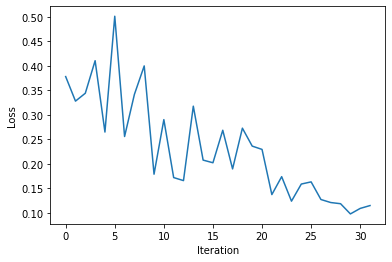

In [31]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()